# TODO: loss < 2.17
1. Padding and rollng window to construct the training data.
2. Construct the MLP: 
   1. Embedding layer (First layer, no non-linearity): Use embedding tensor to embed characters into a 2-dim vector (27 chars in total).
   2. Hidden layers: Use two tensor W and b with tanh.
   3. Output layer: Use two tensor W and b plus a softmax.
3. Use batch gradient descent to train the MLP.
4. Use a list of learning rate during the traning to determine the best learning rate.
5. Try learning rate decay after convergence.
6. 3 data splits: 
   1. Training set: 80% of the data. (Train the parameters)
   2. Validation set: 10% of the data. (Train the hyper-parameters)
   3. Test set: 10% of the data. 
7. Use the validation set to prevent overfitting and underfitting.
8. Enlarge the hidden layer size, scale up the embedding size.
9. Try to sample from the models.

In [ ]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

# Data preparation

In [ ]:
words = open("../names.txt", "r").read().splitlines()
chars = sorted(set('.'.join(words)))
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}

In [ ]:
ratio1 = 0.8
ratio2 = 0.9
chunk = 3

def create_data(ws, chunk=3):
    X = []
    Y = []
    
    for word in ws:
        Xt = [0] * chunk # Cool
        for ch in word + '.': # Dont forget to add ending token.
            X.append(Xt)
            Y.append(stoi[ch])   
            Xt = Xt[1:] + [stoi[ch]]

    return torch.tensor(X), torch.tensor(Y)

n1 = int(ratio1 * len(words))
n2 = int(ratio2 * len(words))
Xt, Yt = create_data(words[:n1], chunk=chunk)
Xdev, Ydev = create_data(words[n1:n2], chunk=chunk)
Xte, Yte = create_data(words[n2:], chunk=chunk)
print(Xt.shape)
print(len(Xdev))

# Construct the MLP

In [ ]:
X_ = F.one_hot(Xt, num_classes=27).float()
print(X_.shape)
W = torch.randn(27, 3)
print((X_ @ W).shape)

In [ ]:
embedding_size = 3

def get_embedding(embedding_size):
    return torch.randn(27, embedding_size, requires_grad=True)

In [ ]:
def get_MLP(chunk, embedding_size, num_neurons):
    Ws = []
    bs = []

    # Input layer
    W = torch.randn(chunk * embedding_size, num_neurons[0], requires_grad=True)
    b = torch.randn(num_neurons[0])
    Ws.append(W)
    bs.append(b)

    # Hidden layer
    for n1, n2 in zip(num_neurons, num_neurons[1:]):
        W = torch.randn(n1, n2, requires_grad=True)
        b = torch.randn(n2, requires_grad=True)
        Ws.append(W)
        bs.append(b)

    # Output layer
    W = torch.randn(num_neurons[-1], 27, requires_grad=True)
    b = torch.randn(27)
    Ws.append(W)
    bs.append(b)

    return Ws, bs

W, b = get_MLP(chunk, embedding_size, [100])
print(W[0].shape)

# Train & val scripts

In [49]:
def go_through(xx, embed, Ws, bs):
    # Through embedding
    xx = F.one_hot(xx, num_classes=27).float()
    xx = (xx @ embed).view(xx.shape[0], -1)

    # Through MLP
    num_layers = len(Ws)
    for i, (W, b) in enumerate(zip(Ws, bs)):
        xx = xx @ W + b
        if i < num_layers - 1: # No activation after the last layer
            xx = F.tanh(xx)
    return xx

In [ ]:
def train_MLP(X, Y, embed, Ws, bs, batch_size, epochs, lr):
    loss_list = []
    for epoch in range(epochs):
        # Zero out the grad (easy to forget)
        embed.grad = None
        for W, b in zip(Ws, bs):
            W.grad = None
            b.grad = None
        
        # Select batch
        indices = torch.randint(low=0, high=X.shape[0], size=(batch_size,))
        xx = X[indices]
        yy = Y[indices]

        xx = go_through(xx, embed, Ws, bs)
        
        # Compute loss
        loss = F.cross_entropy(xx, yy)
        loss.backward()
        loss_list.append(loss.item())

        # Update params (Use tensor.data, because leaf tensor cannot do in-place operations)
        embed.data += -lr * embed.grad
        for W, b in zip(Ws, bs):
            W.data += -lr * W.grad
            if b.requires_grad == True:
                b.data += -lr * b.grad
            
    return loss_list

# embed = get_embedding(embedding_size)
# embed.requires_grad = True
# Ws, bs = get_MLP(chunk, embedding_size, [100])
# loss_list = train_MLP(Xt, Yt, embed, Ws, bs, 64, 10000, 0.1)
# plt.plot(loss_list)

In [ ]:
def dev_MLP(X, Y, embed, Ws, bs):
    xx = F.one_hot(X, num_classes=27).float()
    xx = (xx @ embed).view(xx.shape[0], -1)
    for W, b in zip(Ws, bs):
        xx = xx @ W + b
        xx = F.tanh(xx)
    loss = F.cross_entropy(xx, Y)
    print(f"loss: {loss}")

# Train the MLP

In [68]:
chunk = 3
embedding_size = 3
num_neurons = [50, 100, 25]

embed = get_embedding(embedding_size)
Ws, bs = get_MLP(chunk, embedding_size, num_neurons)

batch_size = 32
epochs = 20000
lr = 0.1

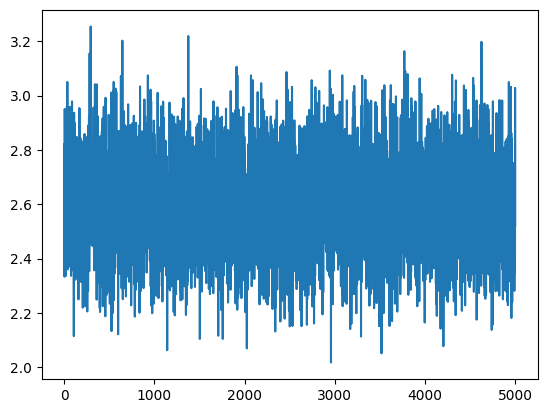

In [71]:
loss_list = train_MLP(Xt, Yt, embed, Ws, bs, batch_size, 5000, 0.01)
plt.plot(loss_list)

In [72]:
dev_MLP(Xdev, Ydev, embed, Ws, bs)

loss: 2.840228319168091


# Infer